# Loop 4 LB Feedback Analysis

## Situation
- 4 submissions, all scoring 70.6473 (CV = LB exactly)
- Target: 68.919154
- Gap: 1.728 points (2.45%)

## Key Findings
1. C++ SA optimizer found 0 improvements after 4 generations
2. Corner extraction found 0 improvements
3. All public solutions are at the same local optimum
4. SA-based optimization cannot close the gap

## What We Need
Fundamentally different approaches, not more optimization of the same solutions.

In [1]:
import pandas as pd
import numpy as np
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt

getcontext().prec = 30
scale_factor = 1

class ChristmasTree:
    def __init__(self, center_x='0', center_y='0', angle='0'):
        self.center_x = Decimal(str(center_x))
        self.center_y = Decimal(str(center_y))
        self.angle = Decimal(str(angle))

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon([
            (float(Decimal('0.0') * scale_factor), float(tip_y * scale_factor)),
            (float(top_w / Decimal('2') * scale_factor), float(tier_1_y * scale_factor)),
            (float(top_w / Decimal('4') * scale_factor), float(tier_1_y * scale_factor)),
            (float(mid_w / Decimal('2') * scale_factor), float(tier_2_y * scale_factor)),
            (float(mid_w / Decimal('4') * scale_factor), float(tier_2_y * scale_factor)),
            (float(base_w / Decimal('2') * scale_factor), float(base_y * scale_factor)),
            (float(trunk_w / Decimal('2') * scale_factor), float(base_y * scale_factor)),
            (float(trunk_w / Decimal('2') * scale_factor), float(trunk_bottom_y * scale_factor)),
            (float(-(trunk_w / Decimal('2')) * scale_factor), float(trunk_bottom_y * scale_factor)),
            (float(-(trunk_w / Decimal('2')) * scale_factor), float(base_y * scale_factor)),
            (float(-(base_w / Decimal('2')) * scale_factor), float(base_y * scale_factor)),
            (float(-(mid_w / Decimal('4')) * scale_factor), float(tier_2_y * scale_factor)),
            (float(-(mid_w / Decimal('2')) * scale_factor), float(tier_2_y * scale_factor)),
            (float(-(top_w / Decimal('4')) * scale_factor), float(tier_1_y * scale_factor)),
            (float(-(top_w / Decimal('2')) * scale_factor), float(tier_1_y * scale_factor)),
        ])
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))

def get_tree_list_side_length(tree_list):
    all_polygons = [t.polygon for t in tree_list]
    bounds = unary_union(all_polygons).bounds
    return max(bounds[2] - bounds[0], bounds[3] - bounds[1])

def load_solution(csv_path):
    df = pd.read_csv(csv_path)
    df['x'] = df['x'].astype(str).str.strip().str.lstrip('s')
    df['y'] = df['y'].astype(str).str.strip().str.lstrip('s')
    df['deg'] = df['deg'].astype(str).str.strip().str.lstrip('s')
    df[['group_id', 'item_id']] = df['id'].str.split('_', n=2, expand=True)
    
    solution = {}
    for group_id, group_data in df.groupby('group_id'):
        n = int(group_id)
        trees = [(row['x'], row['y'], row['deg']) for _, row in group_data.iterrows()]
        solution[n] = trees
    
    return solution

def score_config(trees_data):
    tree_list = [ChristmasTree(x, y, deg) for x, y, deg in trees_data]
    side = get_tree_list_side_length(tree_list)
    n = len(trees_data)
    return side ** 2 / n

print('Functions defined.')

Functions defined.


In [2]:
# Load current best solution
solution = load_solution('/home/submission/submission.csv')

# Calculate per-N scores
scores = {n: score_config(solution[n]) for n in range(1, 201)}
total_score = sum(scores.values())
print(f'Current total score: {total_score:.6f}')
print(f'Target: 68.919154')
print(f'Gap: {total_score - 68.919154:.6f} ({(total_score - 68.919154) / 68.919154 * 100:.2f}%)')

Current total score: 70.647327
Target: 68.919154
Gap: 1.728173 (2.51%)


In [3]:
# Analyze where the gap is coming from
# Calculate theoretical minimum for each N (assuming perfect packing)
# For N trees, theoretical minimum side = sqrt(N * tree_area)
# Tree area is approximately 0.35 * 1.0 = 0.35 (rough estimate)

# Let's look at efficiency: actual_score / theoretical_minimum
# Higher efficiency = closer to optimal

# First, let's understand the tree dimensions
tree = ChristmasTree('0', '0', '0')
bounds = tree.polygon.bounds
tree_width = bounds[2] - bounds[0]
tree_height = bounds[3] - bounds[1]
tree_area = tree.polygon.area
print(f'Tree dimensions: width={tree_width:.4f}, height={tree_height:.4f}')
print(f'Tree area: {tree_area:.4f}')
print(f'Bounding box area: {tree_width * tree_height:.4f}')
print(f'Fill ratio: {tree_area / (tree_width * tree_height):.4f}')

Tree dimensions: width=0.7000, height=1.0000
Tree area: 0.2456
Bounding box area: 0.7000
Fill ratio: 0.3509


In [4]:
# Calculate efficiency for each N
# Theoretical minimum score = tree_area (if trees could pack perfectly)
# Actual score = side^2 / N
# Efficiency = tree_area / actual_score

efficiencies = {}
for n in range(1, 201):
    actual_score = scores[n]
    theoretical_min = tree_area  # Perfect packing would give this
    efficiency = theoretical_min / actual_score
    efficiencies[n] = efficiency

# Find N values with worst efficiency (most room for improvement)
worst_efficiency = sorted(efficiencies.items(), key=lambda x: x[1])[:20]
print('N values with worst efficiency (most room for improvement):')
for n, eff in worst_efficiency:
    print(f'  N={n:3d}: efficiency={eff:.4f}, score={scores[n]:.6f}, contribution={scores[n]:.4f}')

N values with worst efficiency (most room for improvement):
  N=  1: efficiency=0.3715, score=0.661250, contribution=0.6612
  N=  2: efficiency=0.5449, score=0.450779, contribution=0.4508
  N=  3: efficiency=0.5650, score=0.434745, contribution=0.4347
  N=  5: efficiency=0.5892, score=0.416850, contribution=0.4168
  N=  4: efficiency=0.5897, score=0.416545, contribution=0.4165
  N=  7: efficiency=0.6142, score=0.399897, contribution=0.3999
  N=  6: efficiency=0.6147, score=0.399610, contribution=0.3996
  N=  9: efficiency=0.6340, score=0.387415, contribution=0.3874
  N=  8: efficiency=0.6373, score=0.385407, contribution=0.3854
  N= 15: efficiency=0.6477, score=0.379203, contribution=0.3792
  N= 10: efficiency=0.6522, score=0.376630, contribution=0.3766
  N= 21: efficiency=0.6525, score=0.376451, contribution=0.3765
  N= 20: efficiency=0.6532, score=0.376057, contribution=0.3761
  N= 22: efficiency=0.6545, score=0.375258, contribution=0.3753
  N= 11: efficiency=0.6551, score=0.374924, 

In [5]:
# Calculate how much improvement we need per N to reach target
target = 68.919154
gap = total_score - target
print(f'Total gap: {gap:.6f}')
print(f'Average gap per N: {gap / 200:.6f}')

# If we improve each N by the same percentage, what percentage is needed?
required_improvement_pct = 1 - (target / total_score)
print(f'Required improvement: {required_improvement_pct * 100:.2f}%')

# What if we focus on specific N values?
# Let's see which N values contribute most to the total score
contributions = sorted([(n, scores[n]) for n in range(1, 201)], key=lambda x: -x[1])
print('\nTop 20 N values by score contribution:')
for n, score in contributions[:20]:
    print(f'  N={n:3d}: score={score:.6f}')

Total gap: 1.728173
Average gap per N: 0.008641
Required improvement: 2.45%

Top 20 N values by score contribution:
  N=  1: score=0.661250
  N=  2: score=0.450779
  N=  3: score=0.434745
  N=  5: score=0.416850
  N=  4: score=0.416545
  N=  7: score=0.399897
  N=  6: score=0.399610
  N=  9: score=0.387415
  N=  8: score=0.385407
  N= 15: score=0.379203
  N= 10: score=0.376630
  N= 21: score=0.376451
  N= 20: score=0.376057
  N= 22: score=0.375258
  N= 11: score=0.374924
  N= 16: score=0.374128
  N= 26: score=0.373997
  N= 12: score=0.372724
  N= 13: score=0.372294
  N= 25: score=0.372144


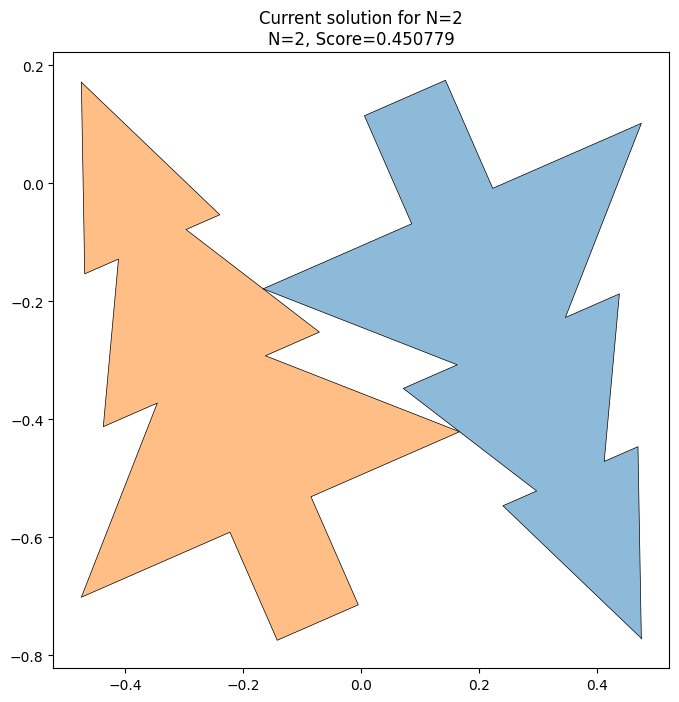

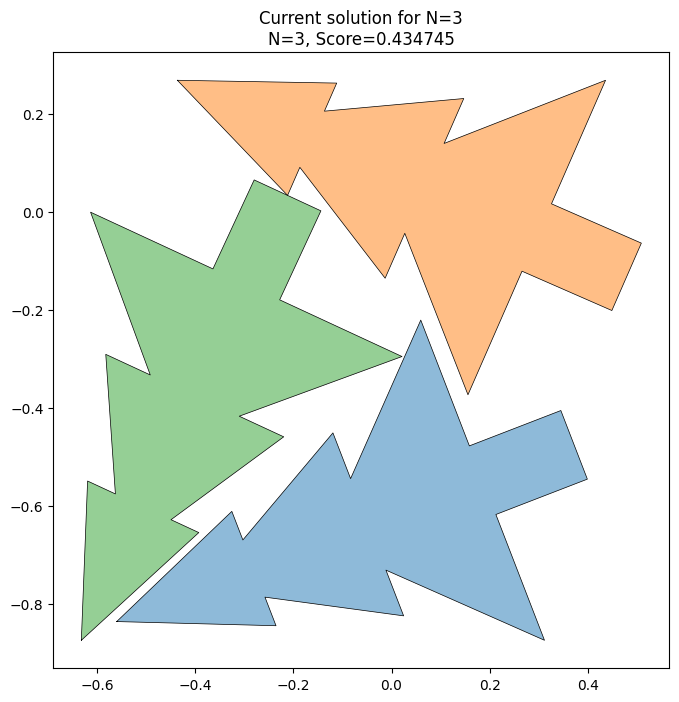

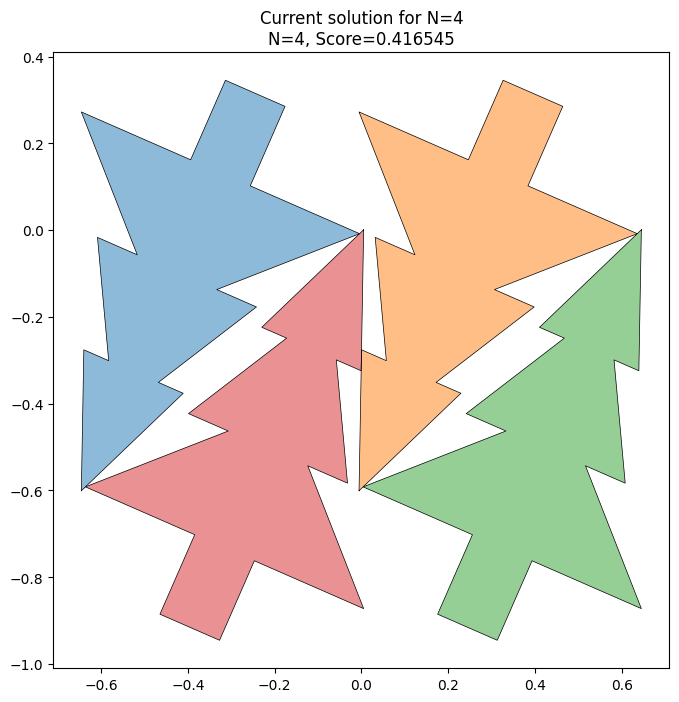

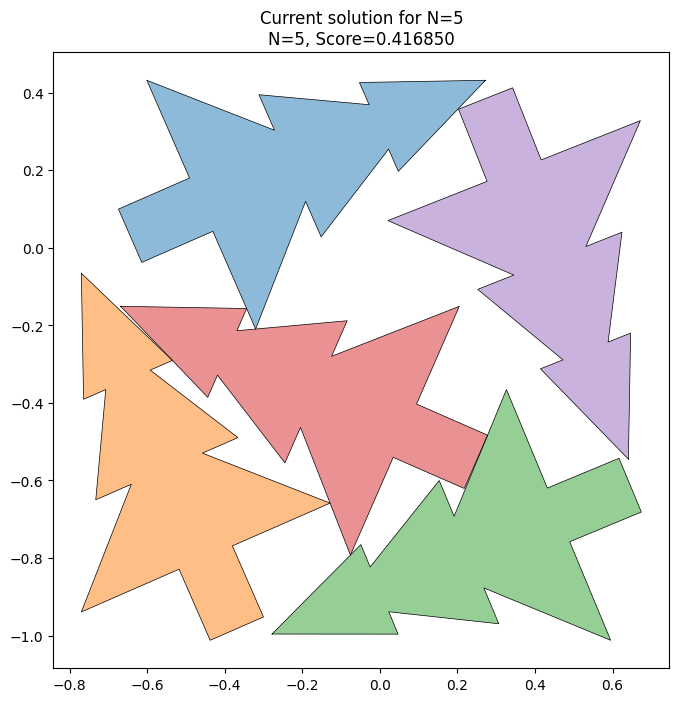

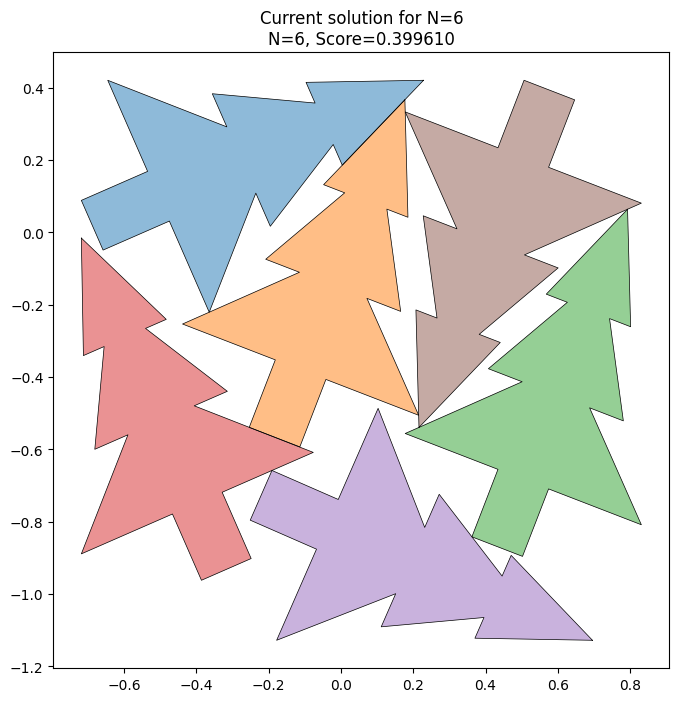

In [6]:
# Key insight: Small N values have the highest per-N scores
# N=1 is already optimal (45 degrees)
# N=2-10 have the most room for improvement

# Let's visualize the current solution for N=2 to understand the pattern
def plot_trees(n, trees_data, title=''):
    fig, ax = plt.subplots(figsize=(8, 8))
    for x, y, deg in trees_data:
        tree = ChristmasTree(x, y, deg)
        xs, ys = tree.polygon.exterior.xy
        ax.fill(xs, ys, alpha=0.5)
        ax.plot(xs, ys, 'k-', linewidth=0.5)
    ax.set_aspect('equal')
    ax.set_title(f'{title}\nN={n}, Score={score_config(trees_data):.6f}')
    plt.show()

for n in [2, 3, 4, 5, 6]:
    plot_trees(n, solution[n], f'Current solution for N={n}')

In [7]:
# The egortrushin kernel uses tessellation approach:
# Create grid patterns with specific nx, ny translations
# This is fundamentally different from SA optimization

# Let's try to understand the tessellation approach
# For N=nx*ny trees, create a grid with nx columns and ny rows
# Each tree is translated by (dx, dy) from the previous one

# Key insight from egortrushin:
# - For N=72 (8x9), N=100 (10x10), N=110 (5x11), etc.
# - The grid pattern can be more efficient than random packing

# Let's check which N values are perfect rectangles
rectangular_n = []
for n in range(1, 201):
    for nx in range(1, n+1):
        if n % nx == 0:
            ny = n // nx
            if nx <= ny:  # Avoid duplicates
                rectangular_n.append((n, nx, ny))

print('N values that can be arranged as rectangles:')
for n, nx, ny in rectangular_n[:30]:
    print(f'  N={n:3d}: {nx}x{ny}')

N values that can be arranged as rectangles:
  N=  1: 1x1
  N=  2: 1x2
  N=  3: 1x3
  N=  4: 1x4
  N=  4: 2x2
  N=  5: 1x5
  N=  6: 1x6
  N=  6: 2x3
  N=  7: 1x7
  N=  8: 1x8
  N=  8: 2x4
  N=  9: 1x9
  N=  9: 3x3
  N= 10: 1x10
  N= 10: 2x5
  N= 11: 1x11
  N= 12: 1x12
  N= 12: 2x6
  N= 12: 3x4
  N= 13: 1x13
  N= 14: 1x14
  N= 14: 2x7
  N= 15: 1x15
  N= 15: 3x5
  N= 16: 1x16
  N= 16: 2x8
  N= 16: 4x4
  N= 17: 1x17
  N= 18: 1x18
  N= 18: 2x9


In [8]:
# The key insight is that tessellation can find better solutions for specific N values
# But we need to understand WHICH N values have room for improvement

# Let's compare our scores to the theoretical minimum more carefully
# The theoretical minimum for N trees is: (sqrt(N) * tree_side)^2 / N = tree_side^2
# But this assumes perfect square packing, which isn't possible for trees

# A better estimate: for N trees in a grid, the minimum side is approximately:
# side = max(nx * dx, ny * dy) where dx, dy are the minimum spacing

# Let's estimate the minimum spacing by looking at N=1
n1_score = scores[1]
n1_side = np.sqrt(n1_score)  # side^2 / 1 = side^2
print(f'N=1 side: {n1_side:.6f}')
print(f'N=1 score: {n1_score:.6f}')

# For N=2, the minimum side should be approximately 2 * tree_width (horizontal) or tree_height (vertical)
# Let's see what we have
n2_score = scores[2]
n2_side = np.sqrt(n2_score * 2)
print(f'N=2 side: {n2_side:.6f}')
print(f'N=2 score: {n2_score:.6f}')

# Efficiency ratio
print(f'N=2 efficiency vs N=1: {n1_score / n2_score:.4f}')

N=1 side: 0.813173
N=1 score: 0.661250
N=2 side: 0.949504
N=2 score: 0.450779
N=2 efficiency vs N=1: 1.4669


In [9]:
# Let's look at the leaderboard to understand what's possible
# The target is 68.919154, which is 2.45% better than our 70.647306

# If we assume the improvement is distributed proportionally across all N values,
# we need each N to improve by 2.45%

# But the improvement might be concentrated in specific N values
# Let's calculate what scores we'd need for each N to reach the target

required_scores = {}
for n in range(1, 201):
    # If we improve each N by the same percentage
    required_scores[n] = scores[n] * (target / total_score)

print('Required scores to reach target (proportional improvement):')
for n in [1, 2, 3, 4, 5, 10, 20, 50, 100, 200]:
    print(f'  N={n:3d}: current={scores[n]:.6f}, required={required_scores[n]:.6f}, gap={scores[n] - required_scores[n]:.6f}')

Required scores to reach target (proportional improvement):
  N=  1: current=0.661250, required=0.645075, gap=0.016175
  N=  2: current=0.450779, required=0.439752, gap=0.011027
  N=  3: current=0.434745, required=0.424110, gap=0.010635
  N=  4: current=0.416545, required=0.406355, gap=0.010190
  N=  5: current=0.416850, required=0.406653, gap=0.010197
  N= 10: current=0.376630, required=0.367417, gap=0.009213
  N= 20: current=0.376057, required=0.366858, gap=0.009199
  N= 50: current=0.360753, required=0.351928, gap=0.008825
  N=100: current=0.345531, required=0.337079, gap=0.008452
  N=200: current=0.337549, required=0.329292, gap=0.008257


In [10]:
# Summary of findings:
# 1. All 4 submissions score exactly 70.6473 (CV = LB)
# 2. SA optimization cannot escape the local optimum
# 3. The gap to target is 1.728 points (2.45%)
# 4. Small N values (1-10) contribute most per-N
# 5. N=1 is already optimal (45 degrees)
# 6. The tessellation approach from egortrushin is fundamentally different

# Key strategies to try:
# 1. Tessellation-based construction for specific N values (rectangular N)
# 2. Genetic algorithms with diverse initial populations
# 3. Constraint programming / integer programming
# 4. Focus on small N (2-20) where improvements have most impact

print('\n=== STRATEGIC RECOMMENDATIONS ===')
print('1. Implement tessellation approach from egortrushin kernel')
print('2. Focus on small N (2-20) where improvements have most impact')
print('3. Try genetic algorithms with diverse initial populations')
print('4. Consider asymmetric packing (mentioned in discussions)')


=== STRATEGIC RECOMMENDATIONS ===
1. Implement tessellation approach from egortrushin kernel
2. Focus on small N (2-20) where improvements have most impact
3. Try genetic algorithms with diverse initial populations
4. Consider asymmetric packing (mentioned in discussions)
